## Task 5 - Modelling

In [24]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import os
import sys
current_dir = os.getcwd()

# Append the parent directory to sys.path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# ignore warrnings
import warnings
warnings.filterwarnings("ignore")

In [25]:
final_merged_df=pd.read_csv('../data/final_merged_data.csv')

In [27]:
final_merged_df

,CustomerId,PricingStrategy,FraudResult,Total_Transaction_Amount,Transaction_Count,Std_Transaction_Amount,ProviderId1,ProviderId2,ProviderId3,ProviderId4,...,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ChannelId1,ChannelId2,ChannelId3,ChannelId5,Risk_category
0,CustomerId_4406,2,0,0.557522,119,0.000919,0,0,0,0,...,0,0,0,0,0,0,0,1,0,good
1,CustomerId_4683,2,0,0.556944,2,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,good
2,CustomerId_988,2,0,0.558153,38,0.005187,1,0,0,0,...,0,0,0,0,1,0,0,1,0,good
3,CustomerId_1432,2,0,0.556949,1,0.005449,0,0,0,0,...,0,0,0,0,0,0,0,1,0,good
4,CustomerId_2858,4,0,0.557434,29,0.001660,0,0,0,0,...,0,0,0,0,0,0,0,1,0,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737,CustomerId_3076,2,0,0.556943,4,0.000290,1,0,0,0,...,0,0,0,0,0,0,0,1,0,bad
3738,CustomerId_934,2,0,0.557071,2,0.001068,1,0,0,0,...,0,0,0,0,0,0,0,1,0,bad
3739,CustomerId_893,2,0,0.556973,4,0.001034,1,0,0,0,...,0,0,0,1,0,0,0,1,0,bad
3740,CustomerId_2892,2,0,0.556965,1,0.005449,0,0,0,0,...,0,0,0,0,0,0,0,1,0,bad


In [26]:
final_merged_df.shape

(3742, 49)

In [3]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
final_merged_df['Risk_category'] = label_encoder.fit_transform(final_merged_df['Risk_category'])

### Model Selection and Training

#### 1. Split the Data
- **Objective:** Split the data into training and testing sets to ensure the model's performance is evaluated on unseen data.
- **Method:** Use `train_test_split` from `sklearn` to split the final merged dataset into a training set (for model learning) and a testing set (for performance evaluation).

In [29]:
X = final_merged_df.drop(columns=['CustomerId','Risk_category'])  # Features
y = final_merged_df['Risk_category']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Choose Models
- **Objective**: Train at least two models from the following:
    - Logistic Regression
    - Decision Trees
    - Random Forest
    - Gradient Boosting Machines (GBM)

### Train Logistic Regression

Fit the Logistic Regression model using the training data.

In [31]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

e:\Kiffya_10_acc\Week 6\Bati-Bank-Credit-Scoring-Model\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

#### Train Random Forest
Fit the Random Forest model using the training data.

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 4. Hyperparameter Tuning
**Objective**: Optimize the model performance using hyperparameter tuning techniques:
- Grid Search
- Random Search

In [33]:
from sklearn.model_selection import GridSearchCV
params = {'C': [0.1, 1, 10], 'solver': ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(), param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'solver': ['liblinear']})

### Model Evaluation

#### Metrics:
- **Accuracy**: The ratio of correctly predicted observations to the total observations.
- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
- **Recall (Sensitivity)**: The ratio of correctly predicted positive observations to all actual positives.
- **F1 Score**: The weighted average of Precision and Recall.
- **ROC-AUC**: Area Under the Receiver Operating Characteristic Curve, measures the ability to distinguish between classes.

In [34]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

# Predictions
y_pred_logistic = logistic_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluation Reports
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_logistic))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

# ROC-AUC - For binary classification (need probabilities)
y_proba_logistic = logistic_model.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

roc_auc_logistic = roc_auc_score(y_test, y_proba_logistic)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"Logistic Regression ROC-AUC: {roc_auc_logistic:.2f}")
print(f"Random Forest ROC-AUC: {roc_auc_rf:.2f}")


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.60      0.01      0.02       270
           1       0.64      1.00      0.78       479

    accuracy                           0.64       749
   macro avg       0.62      0.50      0.40       749
weighted avg       0.63      0.64      0.51       749

Random Forest Report:
               precision    recall  f1-score   support

           0       0.55      0.53      0.54       270
           1       0.74      0.76      0.75       479

    accuracy                           0.68       749
   macro avg       0.65      0.64      0.65       749
weighted avg       0.67      0.68      0.68       749

Logistic Regression ROC-AUC: 0.63
Random Forest ROC-AUC: 0.73


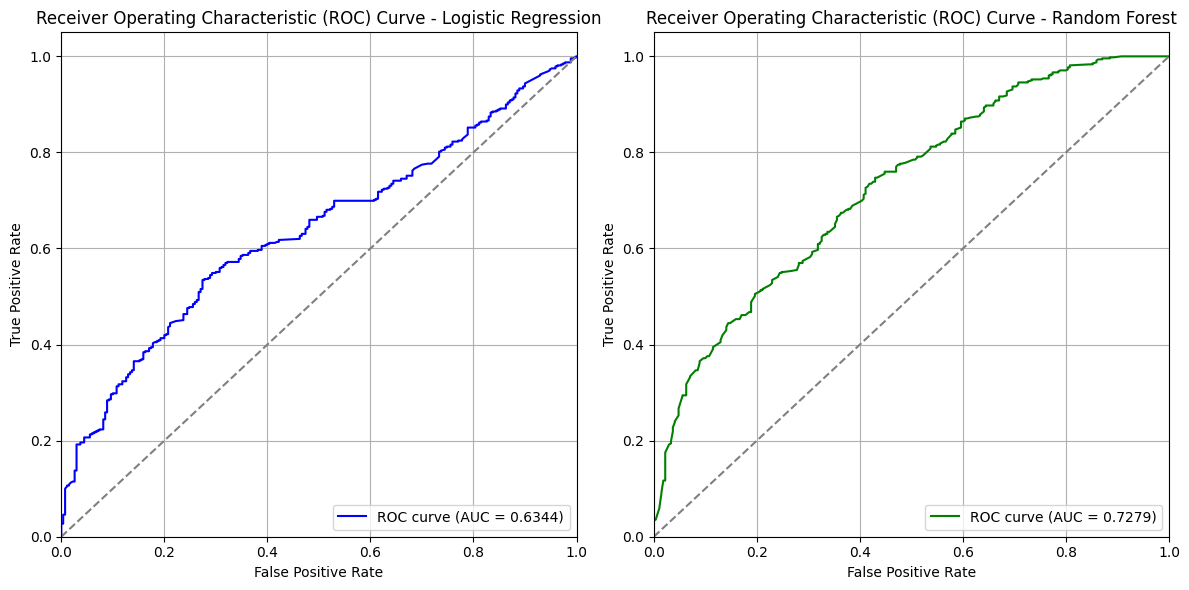

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for Logistic Regression
y_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (e.g., 'good')

# Calculate the ROC curve for Logistic Regression
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_prob_logistic, pos_label=1)  # Ensure pos_label is correct
roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)

# Predict probabilities for Random Forest
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (e.g., 'good')

# Calculate the ROC curve for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf, pos_label=1)  # Ensure pos_label is correct
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

# Create subplots for ROC curves
plt.figure(figsize=(12, 6))

# Subplot for Logistic Regression ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_logistic, tpr_logistic, color='blue', label=f'ROC curve (AUC = {roc_auc_logistic:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)

# Subplot for Random Forest ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr_rf, tpr_rf, color='green', label=f'ROC curve (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [14]:
final_merged_df.drop(columns=['CustomerId']).corr()

,PricingStrategy,FraudResult,Total_Transaction_Amount,Transaction_Count,Std_Transaction_Amount,ProviderId1,ProviderId2,ProviderId3,ProviderId4,ProviderId5,...,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill,ChannelId1,ChannelId2,ChannelId3,ChannelId5,Risk_category
PricingStrategy,1.000000,-0.063898,-0.054726,-0.021534,-0.050921,0.113071,-0.011393,-0.359779,0.240124,0.097164,...,-0.024526,0.040347,-0.033201,-0.084115,-0.085067,-0.011927,0.205794,-0.191107,0.120543,-0.013251
FraudResult,-0.063898,1.000000,0.154195,-0.012769,0.386712,0.011833,-0.001934,0.071397,0.036579,-0.053185,...,-0.001368,-0.009635,-0.003352,-0.010026,0.011463,0.038129,0.046719,-0.052537,-0.007890,-0.015254
Total_Transaction_Amount,-0.054726,0.154195,1.000000,-0.366095,0.509103,0.003194,-0.001449,0.023265,-0.073531,0.008982,...,-0.001021,0.009590,-0.000561,0.004377,-0.000972,0.005961,-0.081421,0.057167,-0.005480,0.025446
Transaction_Count,-0.021534,-0.012769,-0.366095,1.000000,0.002729,-0.030058,-0.005861,-0.014750,0.024199,-0.007046,...,-0.003807,-0.013454,-0.009675,0.023384,-0.010212,-0.011222,0.034717,-0.013384,-0.011727,0.074112
Std_Transaction_Amount,-0.050921,0.386712,0.509103,0.002729,1.000000,0.024055,0.000239,0.056844,0.005833,-0.050296,...,-0.002833,0.035790,0.004545,0.000816,-0.001737,0.014457,0.012016,-0.013290,-0.009057,-0.023253
ProviderId1,0.113071,0.011833,0.003194,-0.030058,0.024055,1.000000,-0.014509,-0.203761,-0.119505,-0.640305,...,-0.010258,-0.009613,0.004528,0.000146,-0.041290,-0.024355,-0.102894,0.112874,-0.059183,-0.055704
ProviderId2,-0.011393,-0.001934,-0.001449,-0.005861,0.000239,-0.014509,1.000000,-0.007510,-0.004405,-0.023599,...,-0.000378,-0.002664,-0.000927,-0.002772,-0.003262,-0.003075,-0.003792,0.005437,-0.002181,-0.006056
ProviderId3,-0.359779,0.071397,0.023265,-0.014750,0.056844,-0.203761,-0.007510,1.000000,-0.061855,-0.331418,...,0.050344,0.010605,-0.013014,0.014963,0.006811,0.026450,-0.053257,0.035519,-0.030633,0.019331
ProviderId4,0.240124,0.036579,-0.073531,0.024199,0.005833,-0.119505,-0.004405,-0.061855,1.000000,-0.194376,...,-0.003114,-0.021940,-0.007633,-0.010526,0.057236,-0.025324,0.860998,-0.810146,0.495230,0.047814
ProviderId5,0.097164,-0.053185,0.008982,-0.007046,-0.050296,-0.640305,-0.023599,-0.331418,-0.194376,1.000000,...,-0.016685,0.014119,0.012547,-0.004697,-0.004798,0.003437,-0.167358,0.158344,-0.096261,-0.048976


In [17]:
from scripts.model_development_scripts import ModelEvaluator
    
evaluator = ModelEvaluator(final_merged_df.drop(columns=['CustomerId','ProductId23','ProductId22']), target_column='Risk_category')

In [18]:
 # Execute each step sequentially
evaluator.split_data()

Data split into training and testing sets.


In [19]:
evaluator.train_logistic_regression()

Logistic Regression model trained.


In [20]:
evaluator.train_random_forest()

Random Forest model trained.


In [21]:
evaluator.predict_probabilities()

Predicted probabilities for Logistic Regression.
Predicted probabilities for Random Forest.


In [22]:
evaluator.calculate_roc_curves()

Calculated ROC curve for Logistic Regression (AUC = 0.6345).
Calculated ROC curve for Random Forest (AUC = 0.7250).


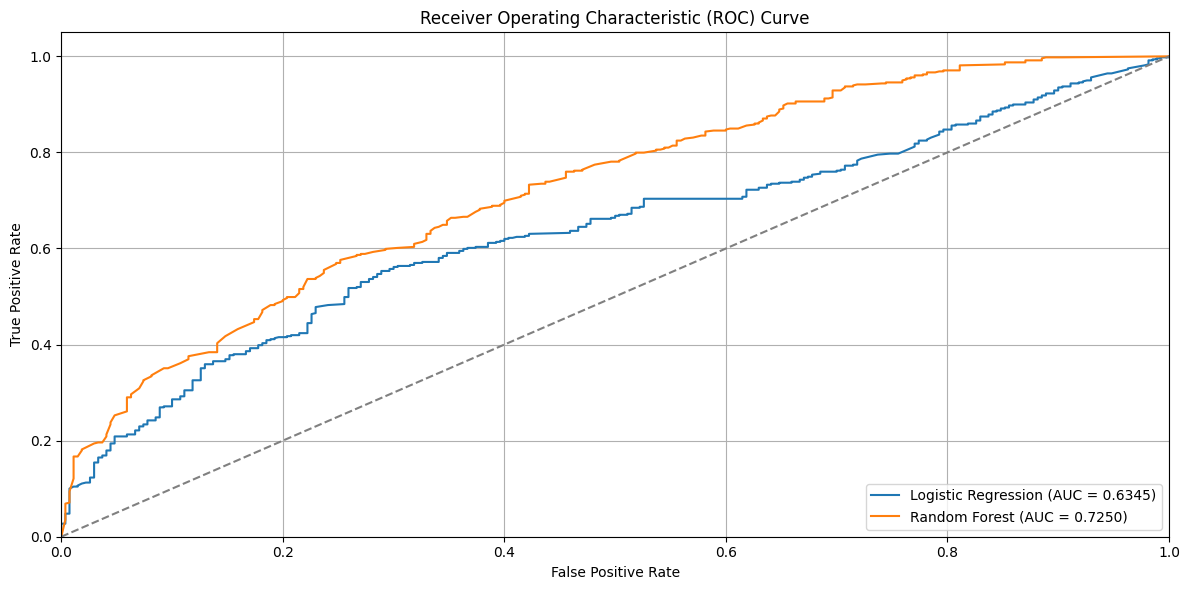

ROC curves plotted.


In [23]:
evaluator.plot_roc_curves()

In [11]:
evaluator.generate_classification_reports()

Classification report generated for Logistic Regression.
Classification report generated for Random Forest.


In [12]:
evaluator.display_classification_reports()

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.50      0.01      0.02       270
           1       0.64      0.99      0.78       479

    accuracy                           0.64       749
   macro avg       0.57      0.50      0.40       749
weighted avg       0.59      0.64      0.51       749

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.55      0.52      0.53       270
           1       0.74      0.76      0.75       479

    accuracy                           0.67       749
   macro avg       0.64      0.64      0.64       749
weighted avg       0.67      0.67      0.67       749

